[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bachhvu/Amazon-NLP/blob/main/Model%20Development.ipynb)



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Preprocessed Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, LSTM, SpatialDropout1D, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import AUC
import gensim
import itertools
from sklearn.utils import class_weight
import pickle
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/Electronics_processed.csv', index_col=0)
df

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,review_text,review_time
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",5.0,1370131200,got ta gps got gps husband otr road trucker im...,2013-06-02
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]",1.0,1290643200,disappointed professional otr truck driver bou...,2010-11-25
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]",3.0,1283990400,impression well say unit truck four day prior ...,2010-09-09
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]",2.0,1290556800,great grafics poor gps going write long review...,2010-11-24
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",1.0,1317254400,major issue excuse support mine year got try r...,2011-09-29
...,...,...,...,...,...,...,...,...
1689183,A34BZM6S9L7QI4,B00LGQ6HL8,"Candy Cane ""Is it just me?""","[1, 1]",5.0,1405555200,boom pop pow deliver burned listening hour sin...,2014-07-17
1689184,A1G650TTTHEAL5,B00LGQ6HL8,"Charles Spanky ""Zumina Reviews""","[0, 0]",5.0,1405382400,thin light without compromising sound quality ...,2014-07-15
1689185,A25C2M3QF9G7OQ,B00LGQ6HL8,Comdet,"[0, 0]",5.0,1405555200,form factor durability better sound quality im...,2014-07-17
1689186,A1E1LEVQ9VQNK,B00LGQ6HL8,J. Chambers,"[0, 0]",5.0,1405641600,superb audio quality comfortable set earphone ...,2014-07-18


In [3]:
df = df.sample(n = 10000, random_state=42)

In [ ]:
df.to_csv('/content/drive/MyDrive/Dataset/sample_data.csv')

# Extra Data Wrangling

In [4]:
df['rating_class'] = df['overall'].apply(lambda x: 0 if x < 3 else (2 if x == 3 else 1))
df = df[(df[['rating_class']] != 2).all(axis=1)]
df

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,review_text,review_time,rating_class
1360852,AVCMFK6FBAXO3,B0083C8B30,"Edward Jasudowich ""Edsgolfin""","[1, 1]",5.0,1358985600,switch pioneer simplifed life improved home th...,2013-01-24,1
1672835,A3M64BWMQO6JAL,B00GTGETFG,Amazon Customer,"[0, 0]",5.0,1400630400,power demand lot power needed use charge three...,2014-05-21,1
1626762,A1S9FUIB8R4ZO7,B00DTPYRKC,L T.,"[0, 0]",5.0,1387843200,replacement hdd macbook pro bought ssd replace...,2013-12-24,1
62247,A1V7MCPGTUJ6YY,B00009EHJV,"Bud ""Mac user""","[0, 0]",5.0,1303430400,work great mac vmware fusion installed mac usi...,2011-04-22,1
568677,A3Q2XTSWJBGB89,B0027JRX52,Marcos,"[0, 0]",4.0,1347667200,good solution carry necessary gear occasion wa...,2012-09-15,1
...,...,...,...,...,...,...,...,...,...
595429,AB9XCP6EV8YIP,B002G1YPH0,G L Allen,"[0, 0]",2.0,1386028800,large could fit tower tried using huge difficu...,2013-12-03,0
1352736,A4B4AIBQ9MZHS,B0081UUYWA,"Benjamin Morris ""Cakeisalye""","[0, 0]",5.0,1381017600,great size price got tv steal cyber monday tv ...,2013-10-06,1
152415,A21JUL5XFMS8R,B0009F3SGE,"Rob ""ChaRob""","[0, 0]",5.0,1176422400,awesome bought little guy year ago use gym gre...,2007-04-13,1
551823,A3BWZ0W25CK3LE,B001XURP7W,andreoso,"[15, 16]",1.0,1349049600,recommend flash drive cruzer worked one week d...,2012-10-01,0


In [5]:
##########################################
## Classify ratings as good
##########################################

good_rate = len(df[df['rating_class'] == 1])
bad_rate = len(df[df['rating_class'] == 0])

# Printing rates and their total numbers
print ('Good ratings : {} reviews for products'.format(good_rate))
print ('Bad ratings : {} reviews for products'.format(bad_rate))

Good ratings : 8024 reviews for products
Bad ratings : 1100 reviews for products


In [6]:
df['review_time'] = pd.to_datetime(df['review_time'], format='%Y/%m/%d')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [7]:
df = df.dropna(subset=['review_text'])

In [8]:
df['review_text'].isnull().values.any()

False

# Exploratory Data Analysis

Summary Statistics

In [10]:
# Statistics of non-numeric variables

# Number of unique customers
print('\nNumber of unique customers : {}'.format(len(df['reviewerID'].unique())))
      
# Number of unique products
print('\nNumber of unique products : {}'.format(len(df['asin'].unique())))
      
# Review number per unique customer
print('\nReview per customer: {}'.format((len(df)/len(df['reviewerID'].unique()))))      

# Review number per unique product 
print('\nReview per product: {}'.format((len(df)/len(df['asin'].unique()))))


Number of unique customers : 8774

Number of unique products : 6742

Review per customer: 1.039890585821746

Review per product: 1.3533076238504895


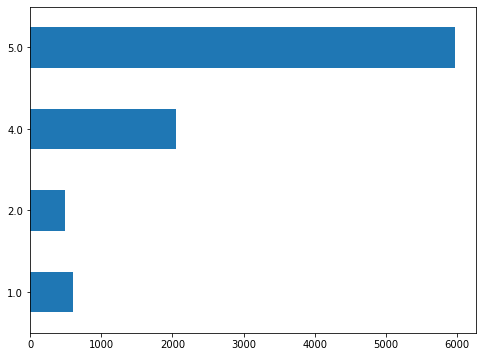

In [ ]:
plt.figure(figsize=(8,6))
df['overall'].value_counts().sort_index().plot(kind="barh")

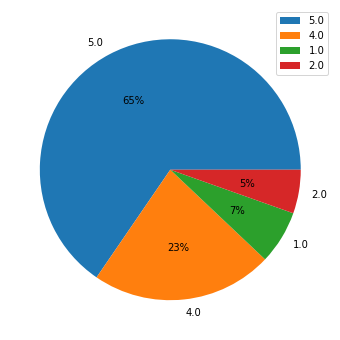

In [ ]:
plt.figure(figsize=(8,6))
plt.pie(df['overall'].value_counts(), labels = df['overall'].value_counts().index, autopct='%1.0f%%')
plt.legend()

Plot number of review per day

In [ ]:
from matplotlib.dates import MonthLocator, YearLocator, DateFormatter
import matplotlib.ticker as ticker
from datetime import datetime, timedelta

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
fig.patch.set_facecolor('#E8E5DA')

ax.plot(df.groupby(pd.Grouper(key='review_time', freq='M')).count().sort_index().index, df.groupby(pd.Grouper(key='review_time', freq='M')).count()['review_text'])
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y'))
ax.xaxis.set_tick_params(rotation=45)
ax.set_xlabel("Year", fontsize=10)
ax.set_ylabel("Number of Reviews", fontsize=10)
ax.grid()

Plot number of unique customer leaving review per month

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
fig.patch.set_facecolor('#E8E5DA')

ax.plot(df.groupby(pd.Grouper(key='review_time', freq='M')).count().sort_index().index, df.groupby(pd.Grouper(key='review_time', freq='M')).count()['reviewerID'])
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y'))
ax.xaxis.set_tick_params(rotation=45)
ax.set_xlabel("Year", fontsize=10)
ax.set_ylabel("Number of Reviewers", fontsize=10)
ax.grid()

Plot number of product reviewed per month

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(df.groupby(pd.Grouper(key='review_time', freq='M')).count().sort_index().index, df.groupby(pd.Grouper(key='review_time', freq='M')).count()['asin'])
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y'))
ax.xaxis.set_tick_params(rotation=45)
ax.set_xlabel("Year", fontsize=10)
ax.set_ylabel("Number of Product Reviewed", fontsize=10)
ax.grid()


In [ ]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(18, 6))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

In [ ]:
# Import package
from wordcloud import WordCloud, STOPWORDS
# Generate word cloud
wordcloud = WordCloud(width= 800, height = 800, random_state=1, background_color='white', stopwords = STOPWORDS).generate(str(df['review_text'].values))
# Plot
plot_cloud(wordcloud)

# Feature Extraction

Split the data into train and test subset

In [10]:
X = df['review_text']
y = df['rating_class']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## TF-IDF

In [11]:
# create the object of tfid vectorizer
tfid_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=5, max_df=0.7, use_idf=True)
# fit the vectorizer using the text data
tfid = tfid_vectorizer.fit(x_train)
# collect the vocabulary items used in the vectorizer
dictionary = tfid_vectorizer.vocabulary_.items()

tfid_matrix_train = tfid_vectorizer.transform(x_train).todense()
tfid_matrix_test = tfid_vectorizer.transform(x_test).todense()
feature_names = tfid_vectorizer.get_feature_names()

# store the tf-idf array into pandas dataframe
x_train = pd.DataFrame(tfid_matrix_train, columns=feature_names)
x_test = pd.DataFrame(tfid_matrix_test, columns=feature_names)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [13]:
print(x_train.shape)
print(x_test.shape)

(6843, 12173)
(2281, 12173)


In [14]:
pickle.dump(tfid_vectorizer.vocabulary_,open("/content/drive/MyDrive/feature.pkl","wb"))

## Word2Vec

In [41]:
documents = [_text.split() for _text in x_train]

In [42]:
w2v_model = gensim.models.word2vec.Word2Vec(size=300, window=7, min_count=5, workers=8)

In [43]:
w2v_model.build_vocab(documents)
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 5441


In [44]:
w2v_model.train(documents, total_examples=len(documents), epochs=32)

(11223756, 12938752)

In [45]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 24624


In [46]:
x_train = pad_sequences(tokenizer.texts_to_sequences(x_train), maxlen=300)
x_test = pad_sequences(tokenizer.texts_to_sequences(x_test), maxlen=300)

#Feature Selection

In [12]:
chi2score = chi2(x_train, y_train)[0]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 0, '$\\chi^2$')

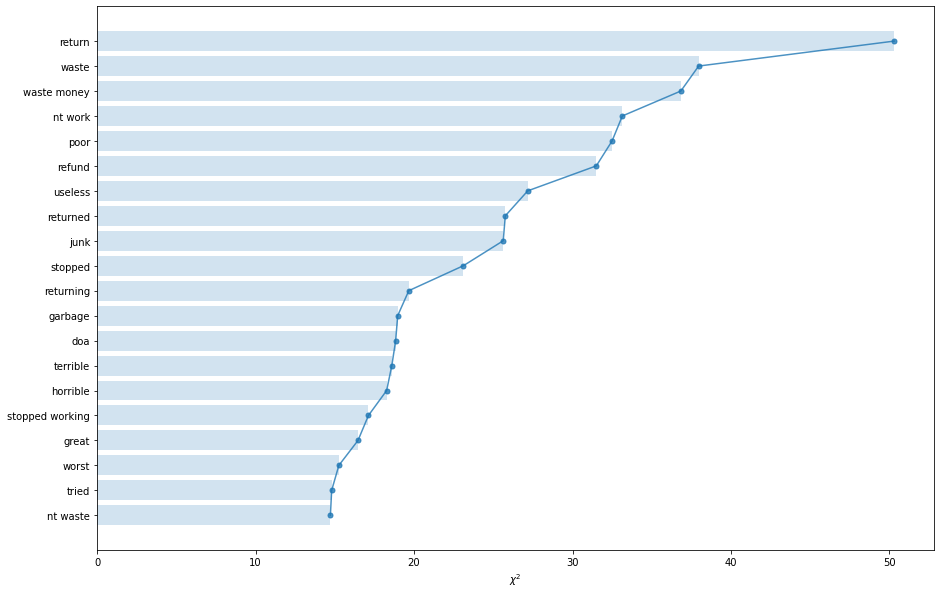

In [13]:
plt.figure(figsize=(15,10))
wscores = list(zip(tfid_vectorizer.get_feature_names(), chi2score))
wchi2 = sorted(wscores, key=lambda x:x[1])
topchi2 = list(zip(*wchi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.2)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')

In [14]:
chi_selector = SelectKBest(chi2, k=10000)
chi_selector.fit(x_train, y_train)
x_train = chi_selector.transform(x_train)
x_test = chi_selector.transform(x_test)

# Model Development

In [15]:
from sklearn.metrics import precision_recall_curve, average_precision_score, make_scorer
aucpr_score = make_scorer(average_precision_score, pos_label=1)

## Naive Bayes

In [16]:
from sklearn.naive_bayes import MultinomialNB

In [17]:
classifier = MultinomialNB()

In [18]:
alpha_list = np.linspace(0.2,1,5)
alpha_list = np.around(alpha_list, decimals=4)
kf = StratifiedKFold(n_splits=30, shuffle=False)
params = {'alpha': alpha_list}

In [19]:
import time
start_time = time.time()
NBClassifier = GridSearchCV(classifier, param_grid=params, cv=kf, n_jobs=-1, verbose=1, scoring=aucpr_score).fit(x_train, y_train)
train_time = time.time() - start_time
print('Done training in', train_time, 'seconds.')

Fitting 30 folds for each of 5 candidates, totalling 150 fits
Done training in 224.1195728778839 seconds.


{'alpha': 0.2}
0.904069745440681
0.009012392484806023


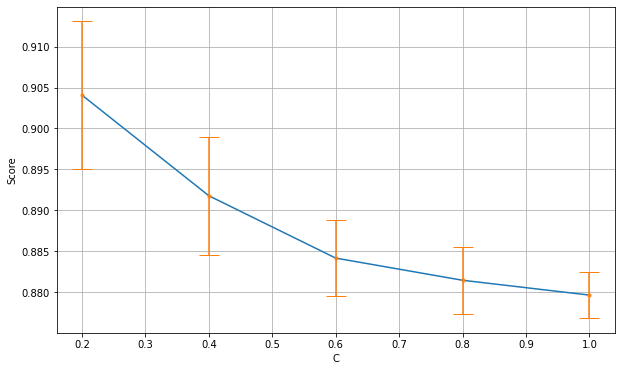

In [20]:
results = pd.DataFrame()
# collect parameter list
results['alpha'] = NBClassifier.cv_results_['param_alpha'].data
# collect test scores
results['score'] = NBClassifier.cv_results_['mean_test_score'].data
#collect standard deviations
results['std'] = NBClassifier.cv_results_['std_test_score'].data

plt.rcParams['figure.figsize'] = (10, 6)
plt.plot(results['alpha'], results['score'])
plt.errorbar(results['alpha'], results['score'], yerr=results['std'], fmt='.', capsize=10)
plt.xlabel('C')
plt.ylabel('Score')
plt.grid()

print(NBClassifier.best_params_)
print(NBClassifier.best_score_)
print(NBClassifier.cv_results_['std_test_score'][NBClassifier.best_index_])

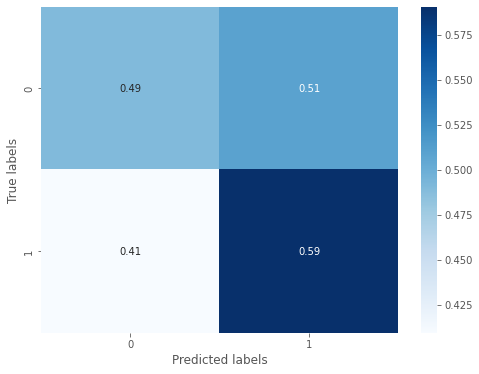

In [72]:
base_preds = NBClassifier.predict(x_test)
labels = df['rating_class'].unique()
cm = confusion_matrix(y_test, base_preds)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.rcParams['figure.figsize'] = (8, 6)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

In [ ]:
#Quick diagnostics
print(classification_report(y_test.astype(str), base_preds.astype(str)))

## Support Vector Machine

In [19]:
classifier = LinearSVC(class_weight='balanced', random_state=0)

In [20]:
alpha_list = np.linspace(0.02,0.1,5)
alpha_list = np.around(alpha_list, decimals=4)
kf = StratifiedKFold(n_splits=30, shuffle=False)
params = {'C': alpha_list}

In [22]:
import time
start_time = time.time()
SVCClassifier = GridSearchCV(classifier, param_grid=params, cv=kf, n_jobs=-1, verbose=1, scoring=aucpr_score).fit(x_train, y_train)
train_time = time.time() - start_time
print('Done training in', train_time, 'seconds.')

Fitting 30 folds for each of 5 candidates, totalling 150 fits
Done training in 229.23351788520813 seconds.


{'C': 0.08}
0.963857859490638
0.009991762365564422


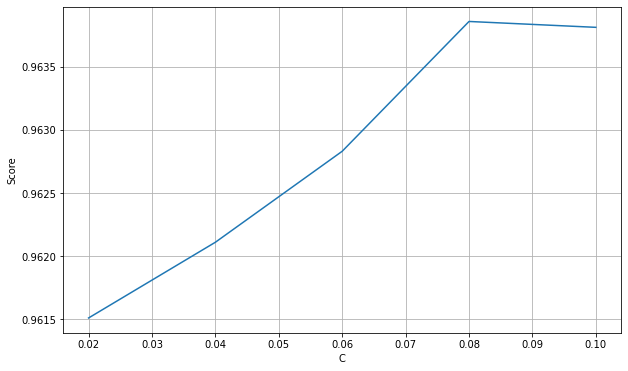

In [23]:
results = pd.DataFrame()
# collect parameter list
results['alpha'] = SVCClassifier.cv_results_['param_C'].data
# collect test scores
results['score'] = SVCClassifier.cv_results_['mean_test_score'].data
#collect standard deviations
results['score'] = NBClassifier.cv_results_['std_test_score'].data

plt.rcParams['figure.figsize'] = (10, 6)
plt.plot(results['alpha'], results['score'])
plt.errorbar(results['alpha'], results['score'], yerr=results['std'], fcapsize=10)
plt.xlabel('C')
plt.ylabel('Score')
plt.grid()

print(SVCClassifier.best_params_)
print(SVCClassifier.best_score_)
print(SVCClassifier.cv_results_['std_test_score'][SVCClassifier.best_index_])

In [ ]:
SVCClassifier = classifier.fit(x_train, y_train)

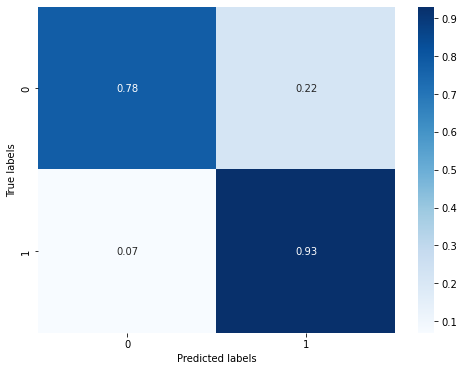

In [24]:
base_preds = SVCClassifier.predict(x_test)
labels = df['rating_class'].unique()
cm = confusion_matrix(y_test, base_preds)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.rcParams['figure.figsize'] = (8, 6)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

In [ ]:
#Quick diagnostics
print(classification_report(y_test.astype(str), base_preds.astype(str)))

              precision    recall  f1-score   support

          -1       0.56      0.79      0.66       271
           1       0.97      0.92      0.94      2010

    accuracy                           0.90      2281
   macro avg       0.77      0.85      0.80      2281
weighted avg       0.92      0.90      0.91      2281



## Logistic Regression

In [25]:
classifier = LogisticRegression(random_state=0, class_weight='balanced')

In [26]:
alpha_list = np.linspace(0.8,1.2,5)
alpha_list = np.around(alpha_list, decimals=4)
kf = StratifiedKFold(n_splits=30, shuffle=False)
params = {'C': alpha_list}

In [27]:
import time
start_time = time.time()
LRClassifier = GridSearchCV(classifier, param_grid=params, cv=kf, n_jobs=-1, verbose=1, scoring=aucpr_score).fit(x_train, y_train)
train_time = time.time() - start_time
print('Done training in', train_time, 'seconds.')

Fitting 30 folds for each of 5 candidates, totalling 150 fits
Done training in 690.8538081645966 seconds.


{'C': 0.9}
0.9634430750352807
0.009647867147663556


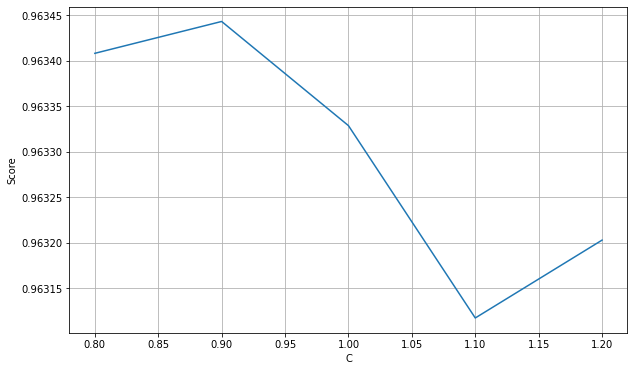

In [28]:
results = pd.DataFrame()
# collect parameter list
results['alpha'] = LRClassifier.cv_results_['param_C'].data
# collect test scores
results['score'] = LRClassifier.cv_results_['mean_test_score'].data
#collect standard deviations
results['score'] = NBClassifier.cv_results_['std_test_score'].data

plt.rcParams['figure.figsize'] = (10, 6)
plt.plot(results['alpha'], results['score'])
plt.errorbar(results['alpha'], results['score'], yerr=results['std'], fmt='.', capsize=10)
plt.xlabel('C')
plt.ylabel('Score')
plt.grid()

print(LRClassifier.best_params_)
print(LRClassifier.best_score_)
print(LRClassifier.cv_results_['std_test_score'][LRClassifier.best_index_])

In [ ]:
LRClassifier = classifier.fit(x_train, y_train)

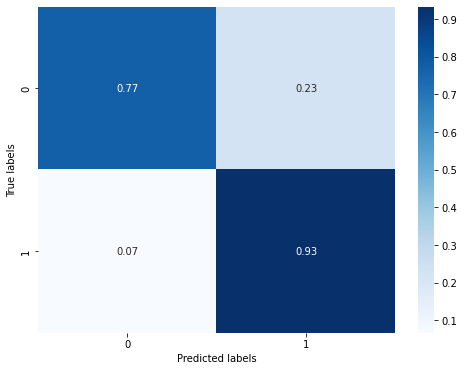

In [30]:
base_preds = LRClassifier.predict(x_test)
labels = df['rating_class'].unique()
cm = confusion_matrix(y_test, base_preds)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.rcParams['figure.figsize'] = (8, 6)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

In [ ]:
#Quick diagnostics
print(classification_report(y_test.astype(str), base_preds.astype(str)))

              precision    recall  f1-score   support

          -1       0.62      0.77      0.69       271
           1       0.97      0.94      0.95      2010

    accuracy                           0.92      2281
   macro avg       0.80      0.86      0.82      2281
weighted avg       0.93      0.92      0.92      2281



## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
classifier = DecisionTreeClassifier(class_weight='balanced')

In [ ]:
DCClassifier = classifier.fit(x_train, y_train)

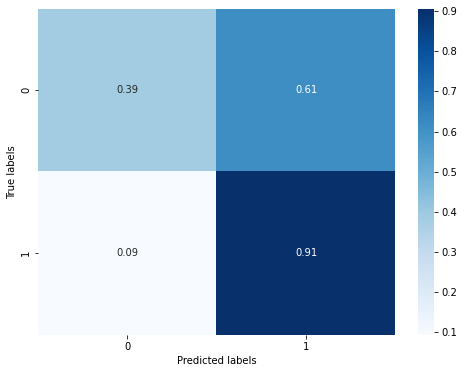

In [ ]:
base_preds = DCClassifier.predict(x_test)
labels = df['rating_class'].unique()
cm = confusion_matrix(y_test, base_preds)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.rcParams['figure.figsize'] = (8, 6)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

In [ ]:
#Quick diagnostics
print(classification_report(y_test.astype(str), base_preds.astype(str)))

              precision    recall  f1-score   support

           0       0.34      0.39      0.36       281
           1       0.92      0.91      0.91      2219

    accuracy                           0.85      2500
   macro avg       0.63      0.65      0.64      2500
weighted avg       0.86      0.85      0.85      2500



## Deep Learning

In [47]:
embedding_matrix = np.zeros((vocab_size,300))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(24624, 300)


In [48]:
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)

In [49]:
model = Sequential()
model.add(embedding_layer)
model.add(SpatialDropout1D(0.3))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.25))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          7387200   
                                                                 
 spatial_dropout1d (SpatialD  (None, 300, 300)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 7,606,977
Trainable params: 219,777
Non-trainable params: 7,387,200
_________________________________________________________________


In [50]:
pr_metric = AUC(curve='PR', num_thresholds=1000) # The higher the threshold value, the more accurate it is calculated.
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=[pr_metric])
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0), EarlyStopping(monitor='val_auc', min_delta=1e-4, patience=5)]

In [51]:
class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = np.ravel(y_train))

class_weights = {i : class_weights[i] for i in range(2)}
class_weights

{0: 4.127261761158022, 1: 0.5689225141336881}

In [54]:
import time
start_time = time.time()
H = model.fit(x_train, y_train, batch_size=1024, epochs=20, class_weight=class_weights, validation_split=0.2, verbose=1, callbacks=callbacks)
train_time = time.time() - start_time
print('Done training in', train_time, 'seconds.')

Epoch 1/20
6/6 [==============================] - 26s 4s/step - loss: 0.5733 - auc: 0.9574 - val_loss: 0.5236 - val_auc: 0.9610 - lr: 0.0010
Epoch 2/20
6/6 [==============================] - 10s 2s/step - loss: 0.5141 - auc: 0.9692 - val_loss: 0.4470 - val_auc: 0.9710 - lr: 0.0010
Epoch 3/20
6/6 [==============================] - 10s 2s/step - loss: 0.4718 - auc: 0.9763 - val_loss: 0.5321 - val_auc: 0.9742 - lr: 0.0010
Epoch 4/20
6/6 [==============================] - 10s 2s/step - loss: 0.4445 - auc: 0.9798 - val_loss: 0.4557 - val_auc: 0.9746 - lr: 0.0010
Epoch 5/20
6/6 [==============================] - 10s 2s/step - loss: 0.4123 - auc: 0.9831 - val_loss: 0.4376 - val_auc: 0.9763 - lr: 0.0010
Epoch 6/20
6/6 [==============================] - 10s 2s/step - loss: 0.4084 - auc: 0.9836 - val_loss: 0.8190 - val_auc: 0.9693 - lr: 0.0010
Epoch 7/20
6/6 [==============================] - 10s 2s/step - loss: 0.4149 - auc: 0.9830 - val_loss: 0.3628 - val_auc: 0.9711 - lr: 0.0010
Epoch 8/20
6/

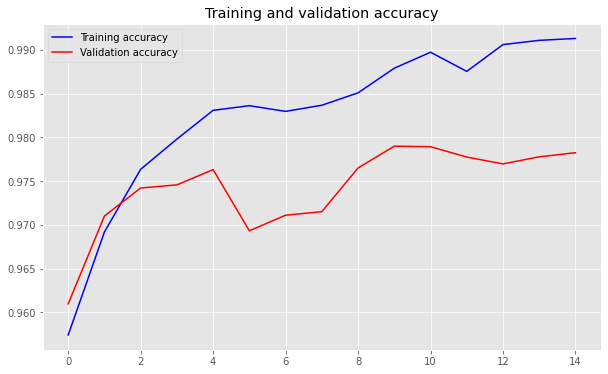

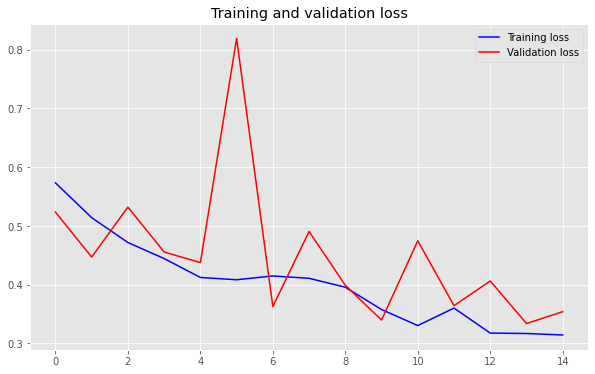

In [55]:
acc = H.history['auc']
val_acc = H.history['val_auc']
loss = H.history['loss']
val_loss = H.history['val_loss']
 
epochs = range(len(acc))

plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (10, 6)

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [57]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub("@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+", ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if stem:
            tokens.append(stemmer.stem(token))
        else:
            tokens.append(token)
    return " ".join(tokens)

def decode_sentiment(score, include_neutral):
    if include_neutral:        
        label = 'NEUTRAL'
        if score <= 0.4:
            label = 'NEGATIVE'
        elif score >= 0.7:
            label = 'POSITIVE'
        return label
    else:
        return 0 if score < 0.5 else 1 

def predict(model, tokenizer, text, include_neutral=False, sequence_length=300):
    
    start_at = time.time()
    # Tokenize text
    text = [preprocess(t) for t in text]
    X = pad_sequences(tokenizer.texts_to_sequences(text), maxlen=sequence_length)
    # Predict
    score = model.predict(X, batch_size=50)
    # Decode sentiment
    labels = []
    for s in score:
        label = decode_sentiment(s, include_neutral=include_neutral)
        labels.append(label)

    return {"label": labels, "score": score,
       "elapsed_time": time.time()-start_at}

In [58]:
%%time
y_pred_1d = []
y_test_1d = list(y_test)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

1/1 [==============================] - 1s 867ms/step
CPU times: user 787 ms, sys: 203 ms, total: 990 ms
Wall time: 963 ms


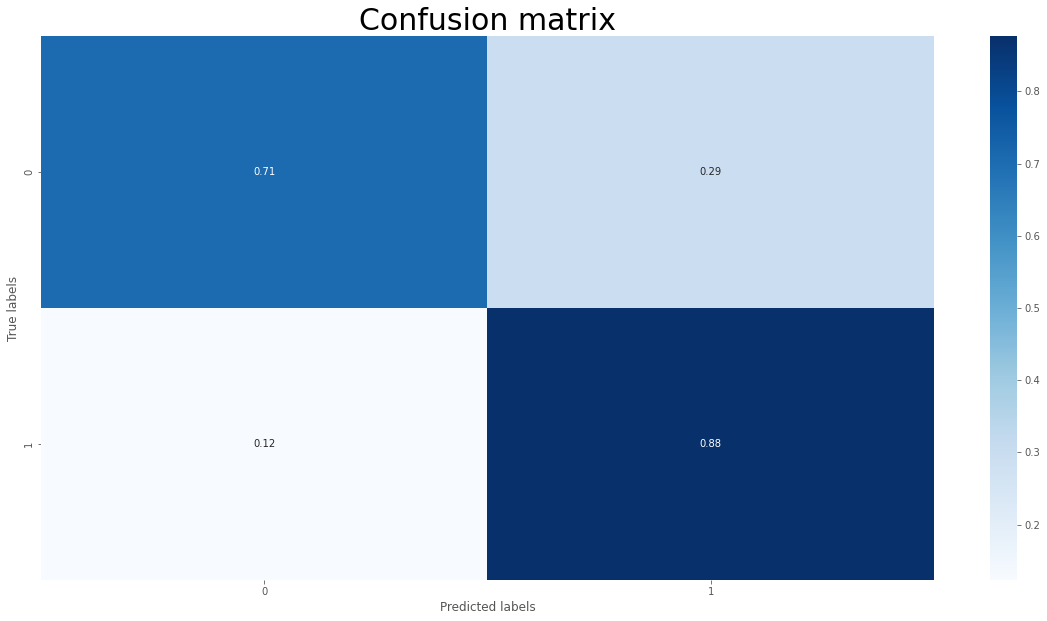

In [59]:
cm = confusion_matrix(y_test_1d, y_pred_1d)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.rcParams['figure.figsize'] = (20, 10)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=True, ax = ax)
plt.title("Confusion matrix", fontsize=30)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

In [60]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

           0       0.44      0.71      0.54       271
           1       0.96      0.88      0.92      2010

    accuracy                           0.86      2281
   macro avg       0.70      0.79      0.73      2281
weighted avg       0.90      0.86      0.87      2281



In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=5000)
print()
print("Area Under Precision-Recall Curve:",score[1])
print("LOSS:",score[0])

1/1 [==============================] - 1s 628ms/step - loss: 0.4964 - auc_3: 0.9804

Area Under Precision-Recall Curve: 0.980376124382019
LOSS: 0.4963921904563904
CPU times: user 416 ms, sys: 222 ms, total: 638 ms
Wall time: 683 ms


# Save model

In [ ]:
pickle.dump(model, open('/content/drive/MyDrive/model.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://ce57f8f8-ffef-41b0-8960-6a032d14db7d/assets


In [ ]:
with open('/content/drive/MyDrive/classifier.pkl', 'wb') as file:  
    pickle.dump(LRClassifier, file)

In [ ]:
!zip -r model.zip {/content/drive/MyDrive}

	zip warning: name not matched: {/content/drive/MyDrive}

zip error: Nothing to do! (try: zip -r model.zip . -i {/content/drive/MyDrive})


drive  sample_data
